# NLP Project Work - Stance classification

In [1]:
%%capture
!pip install transformers
!pip install nltk emoji==0.6.0

In [2]:
import pandas as pd
import sys
import transformers
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModel, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from collections import defaultdict
from sklearn.metrics import f1_score, confusion_matrix#, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [3]:
# set seed

SEED = 0

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Data exploration

Train source: https://alt.qcri.org/semeval2016/task6/data/uploads/semeval2016-task6-trainingdata.txt

Training data are obtained with copying and pasting the text from the previous source. Doing otherwise returns an error when reading the data with pandas.

Test and trial source: http://www.saifmohammad.com/WebDocs/stance-data-all-annotations.zip

Test and trial data can be found in the zip file from the link above.

The final training set is composed by adding trail data to the previous training data (as we can see, the number of instances of the training plus those of trial, matches the number of instances reported in the paper https://aclanthology.org/S16-1003.pdf).

In [6]:
!git clone https://github.com/nicolapoggialini/stance_classification.git

Cloning into 'stance_classification'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), 1.87 MiB | 8.88 MiB/s, done.


In [9]:
!unzip /content/stance_classification/data/semEval2016.zip

Archive:  /content/stance_classification/data/semEval2016.zip
  inflating: semEval2016/test.txt    
  inflating: semEval2016/test_new_target.txt  
  inflating: semEval2016/train.txt   
  inflating: semEval2016/trial.txt   


In [10]:
train = pd.read_csv('/content/semEval2016/train.txt', sep='\t')
train.head()

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST


In [11]:
len(train)

2814

In [12]:
trial = pd.read_csv('/content/semEval2016/trial.txt', sep='\t')
trial.head()

,ID,Target,Tweet,Stance,Opinion towards,Sentiment
0,1,Hillary Clinton,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST,TARGET,NEGATIVE
1,2,Hillary Clinton,Hillary is our best choice if we truly want to...,FAVOR,TARGET,POSITIVE
2,3,Hillary Clinton,@TheView I think our country is ready for a fe...,AGAINST,TARGET,NEGATIVE
3,4,Hillary Clinton,I just gave an unhealthy amount of my hard-ear...,AGAINST,TARGET,NEGATIVE
4,5,Hillary Clinton,@PortiaABoulger Thank you for adding me to you...,NONE,NO ONE,POSITIVE


In [13]:
len(trial)

100

In [14]:
# dropping additional columns

trial = trial.drop(['Opinion towards',	'Sentiment'], axis = 1)
trial.head()

,ID,Target,Tweet,Stance
0,1,Hillary Clinton,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,2,Hillary Clinton,Hillary is our best choice if we truly want to...,FAVOR
2,3,Hillary Clinton,@TheView I think our country is ready for a fe...,AGAINST
3,4,Hillary Clinton,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,5,Hillary Clinton,@PortiaABoulger Thank you for adding me to you...,NONE


In [15]:
train_df = pd.concat([trial, train]).drop('ID', axis = 1)
train_df.head()

,Target,Tweet,Stance
0,Hillary Clinton,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,Hillary Clinton,Hillary is our best choice if we truly want to...,FAVOR
2,Hillary Clinton,@TheView I think our country is ready for a fe...,AGAINST
3,Hillary Clinton,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,Hillary Clinton,@PortiaABoulger Thank you for adding me to you...,NONE


In [16]:
len(train_df)

2914

In [17]:
train_df['Target'].value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

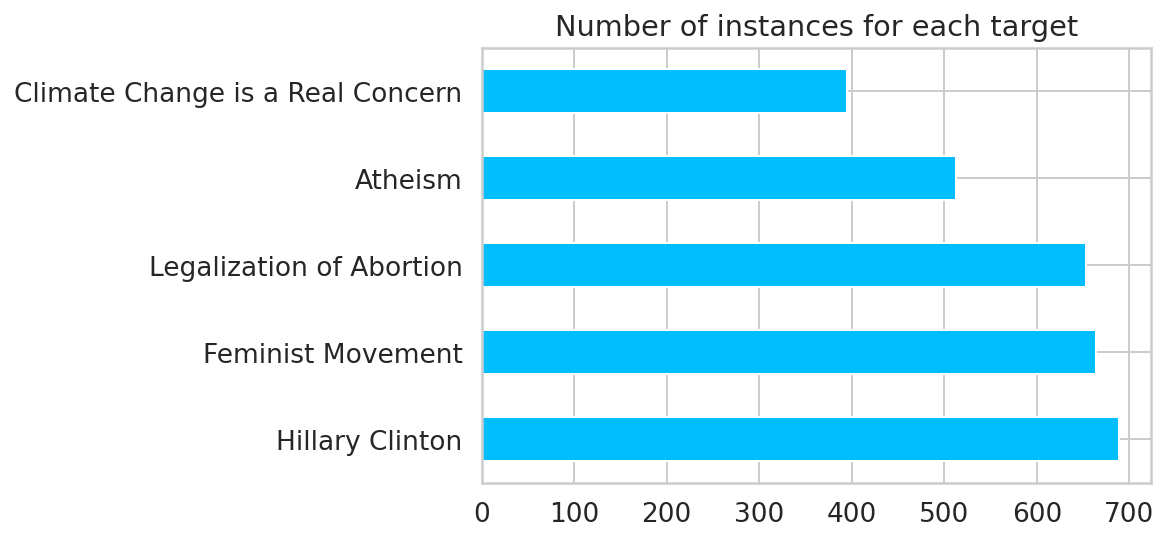

In [18]:
train_df['Target'].value_counts().plot(kind = 'barh', title = 'Number of instances for each target')

The majority of samples belong to the targets about Hillary Clinton, feminism and abortion, which are quite equally distributed. <br> Less instances instead for the targets about atheism and climate change. 

In [19]:
train_df['Stance'].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

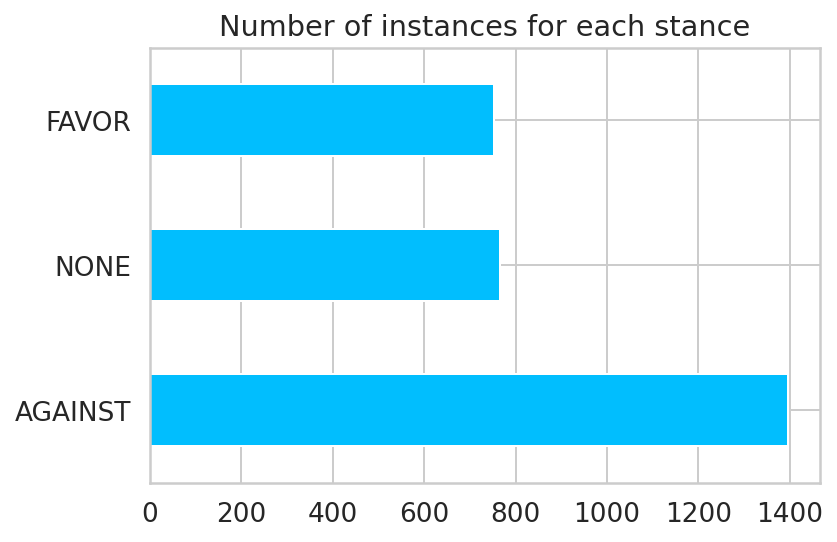

In [20]:
train_df['Stance'].value_counts().plot(kind='barh', title = 'Number of instances for each stance')

We notice un unbalanced distribution regarding the stance. The 'Against' instances double in number each one of the other stances.

In [21]:
# train-validation split

train_df, val_df = train_test_split(
  train_df,
  test_size = 0.1,
  random_state = SEED
)

In [22]:
print('Training set samples: ' + str(len(train_df)))
print('Validation set samples: ' + str(len(val_df)))

Training set samples: 2622
Validation set samples: 292


## Pre-processing

As stated here https://github.com/VinAIResearch/BERTweet#preprocess, we can use the function _normalizeTweet_ to pre-preprocess raw tweets in the same way the authors of BERTweet did.

In [23]:
!git clone https://github.com/VinAIResearch/BERTweet.git

Cloning into 'BERTweet'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 110 (delta 60), reused 14 (delta 6), pack-reused 0
Receiving objects: 100% (110/110), 44.20 KiB | 11.05 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
sys.path.insert(1, '/content/BERTweet')

from TweetNormalizer import normalizeTweet

In [ ]:
train_df['cleaned_tweet'] = train_df.apply(lambda row: normalizeTweet(row['Tweet']), axis = 1)

val_df['cleaned_tweet'] = val_df.apply(lambda row: normalizeTweet(row['Tweet']), axis = 1)

In [ ]:
train_df.head()

,Target,Tweet,Stance,cleaned_tweet
2081,Hillary Clinton,@TODAYshow @ChrisChristie is not qualified b/c...,AGAINST,@USER @USER is not qualified b / c he eats $ 8...
2522,Legalization of Abortion,"on a side note, just because you think smtg is...",NONE,"on a side note , just because you think smtg i..."
462,Atheism,Today you and I have no idea what we will be f...,AGAINST,Today you and I have no idea what we will be f...
1557,Feminist Movement,The lack intellectual integrity in a group of ...,AGAINST,The lack intellectual integrity in a group of ...
1932,Hillary Clinton,@WestonMartinez @crazytas62 Cruz needs to auto...,NONE,@USER @USER Cruz needs to autograph bomb #SemST


In [ ]:
val_df.head()

,Target,Tweet,Stance,cleaned_tweet
1357,Feminist Movement,They don't call it MALE-volent for no reason #...,FAVOR,They do n't call it MALE-volent for no reason ...
2397,Legalization of Abortion,Changing the cis-nomative atmosphere is diffic...,NONE,Changing the cis-nomative atmosphere is diffic...
2304,Legalization of Abortion,"#Hillary, Here's one Christian whose religion ...",AGAINST,"#Hillary , Here 's one Christian whose religio..."
575,Climate Change is a Real Concern,"Let's all stop saying people don't ""believe"" i...",FAVOR,"Let 's all stop saying people do n't "" believe..."
22,Hillary Clinton,Because Communist Breadlines are not my thing!...,AGAINST,Because Communist Breadlines are not my thing ...


In [ ]:
# dictionary with stances' labels as keys and corresponding integer as value

labels_dict = {'AGAINST': 0, 'FAVOR': 1, 'NONE': 2}

In [ ]:
# convert stances' labels to numbers

pd_num_stances_train = train_df['Stance'].map(labels_dict)
train_stances = torch.tensor(pd_num_stances_train.to_list())  

pd_num_stances_val = val_df['Stance'].map(labels_dict)
val_stances = torch.tensor(pd_num_stances_val.to_list())  


## Prepare data

### Input length

In [ ]:
# instantiate BERTweet tokenizer

PRE_TRAINED_MODEL_NAME = "vinai/bertweet-base"

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


First of all, let's check the maximum length accepted from the model and the length of the texts.

In [ ]:
tokenizer.model_max_length

128

In [ ]:
def get_token_lens(data, tokenizer):

  '''
  data: iteratable object with strings as elements
  '''

  token_lens = []

  for d in data:
    tokens = tokenizer.tokenize(d)
    token_lens.append(len(tokens))

  return token_lens

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Tweets')

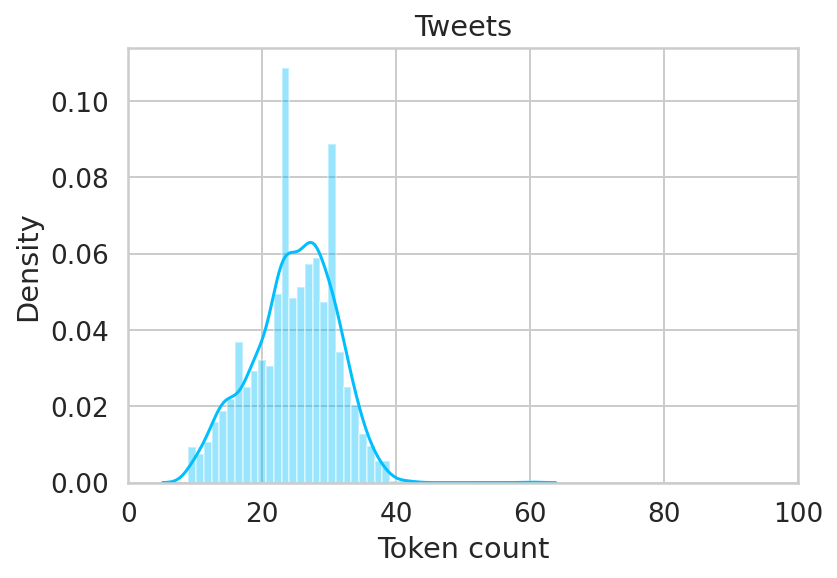

In [ ]:
# tweets lens
tweets_token_lens = get_token_lens(train_df['cleaned_tweet'], tokenizer)

#rcParams['figure.figsize'] = 12, 8

sns.distplot(tweets_token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')
plt.title('Tweets')

All tweets have less than 50 tokens: I'm going to use that as the maximum length of the input sequences.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Targets')

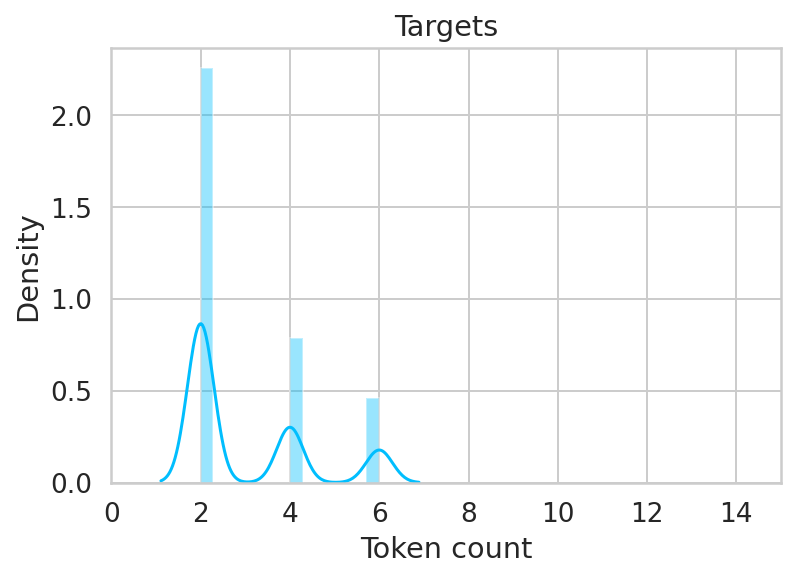

In [ ]:
# targets lens
targets_token_lens = get_token_lens(train_df['Target'], tokenizer)

#rcParams['figure.figsize'] = 12, 8

sns.distplot(targets_token_lens)
plt.xlim([0, 15])
plt.xlabel('Token count')
plt.title('Targets')

Regarding the targets, they are all under 8 tokens, so this will be the max length for them.


In [ ]:
MAX_TWEET_LEN = 50
MAX_TARGET_LEN = 8

### Tokenization

In [ ]:
# convert pandas series to list

train_tweets = train_df['cleaned_tweet'].to_list()
train_targets = train_df['Target'].to_list()

val_tweets = val_df['cleaned_tweet'].to_list()
val_targets = val_df['Target'].to_list()

In [ ]:
# encoding (tokenize text + attention mask + token type)

train_enc_tweets = tokenizer(train_tweets, padding = True, truncation = True, max_length = MAX_TWEET_LEN, return_tensors = 'pt')
train_enc_targets = tokenizer(train_targets, padding = True, truncation = True, max_length = MAX_TARGET_LEN, return_tensors = 'pt')

val_enc_tweets = tokenizer(val_tweets, padding = True, truncation = True, max_length = MAX_TWEET_LEN, return_tensors = 'pt')
val_enc_targets = tokenizer(val_targets, padding = True, truncation = True, max_length = MAX_TARGET_LEN, return_tensors = 'pt')

In [ ]:
print(train_enc_tweets['input_ids'].shape, train_enc_targets['input_ids'].shape)
print(val_enc_tweets['input_ids'].shape, val_enc_targets['input_ids'].shape)

torch.Size([2622, 50]) torch.Size([2622, 8])
torch.Size([292, 50]) torch.Size([292, 8])


### Custom torch dataset

In [ ]:
# create a custom torch dataset

class StanceDataset(Dataset):

    def __init__(self, tweet_encodings, target_encodings, stances):
        self.tweet_encodings = tweet_encodings
        self.target_encodings = target_encodings
        self.stances = stances

    def __len__(self):
        return len(self.stances)

    def __getitem__(self, idx):

        # tweet
        tweet_input_ids = self.tweet_encodings['input_ids'][idx]
        tweet_attention_mask = self.tweet_encodings['attention_mask'][idx]

        # targets
        target_inputs_ids = self.target_encodings['input_ids'][idx]
        target_attention_mask = self.target_encodings['attention_mask'][idx]

        item = {
            'tweet_input_ids': tweet_input_ids,
            'tweet_attention_mask': tweet_attention_mask,
            'target_input_ids': target_inputs_ids,
            'target_attention_mask': target_attention_mask,
            'stances': self.stances[idx]
        }

        return item


In [ ]:
train_dataset = StanceDataset(train_enc_tweets,
                              train_enc_targets,
                              train_stances)

val_dataset = StanceDataset(val_enc_tweets,
                            val_enc_targets,
                            val_stances)

## Model

In [ ]:
class StanceClassifier(nn.Module):
    def __init__(self,
                 hidden_dim,
                 num_layers = 1,
                 n_classes = 3,
                 fine_tuning = True):
      
        '''
        hidden_dims (int): hidden dimension for the BiLSTMs
        num_layers (int): number of stacked BiLSTM layers
        n_classes (int): number of classes
        fine_tuning (boolean): whether or not to fine tune bertweet
        '''
        
        super().__init__()
        self.bertweet = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        if not fine_tuning:
          for param in self.bertweet.parameters():
            param.requires_grad = False

        embedding_dim = self.bertweet.config.to_dict()['hidden_size']

        self.bi_lstm = nn.LSTM(embedding_dim, 
                               hidden_dim,
                               num_layers = num_layers, 
                               bidirectional = True)

        
        self.to_scalar_linear = nn.Linear(embedding_dim*2, 1)
        self.classifier = nn.Linear(hidden_dim*2, n_classes)
        self.softmax = nn.Softmax(dim = 1)

        
    def forward(self,
                tweet_input_ids,
                tweet_attention_mask,
                target_input_ids,
                target_attention_mask):

        # tweet side of the architecture     
        tweet_embeddings = self.bertweet(tweet_input_ids,
                                         tweet_attention_mask)[0]

        bilstm_out, _ = self.bi_lstm(tweet_embeddings)

        # target side
        target_embeddings = self.bertweet(target_input_ids,
                                          target_attention_mask)[0]

        # mean of target embeddings
        mean = torch.mean(target_embeddings, axis = 1, keepdim = True)
        # repeat to have one mean vector per tweet word
        repeated_mean = mean.repeat(1, MAX_TWEET_LEN, 1)
        # target-augmented tweet word embeddings concatenating the mean target vector
        target_aug_tweet = torch.cat((tweet_embeddings, repeated_mean), axis = 2)
        
        # compute attention scores with linear layer and then softmax 
        attention_scores = self.softmax(self.to_scalar_linear(target_aug_tweet))

        # vector representation of the input sequence
        rep_vector = torch.mean(bilstm_out*attention_scores, axis = 1)

        out = self.classifier(rep_vector)

        return out

## Train and evaluation functions

In [ ]:
def train_epoch(model,
                data_loader,
                labels_dict, # dictionary with stance labels and corresponding integer
                loss_fn,
                optimizer,
                device):

  model = model.train()
  losses = []
  true_labels = []
  pred_labels = []

  for batch in data_loader:

    # tweet inputs
    tweet_ids = batch['tweet_input_ids'].to(device)
    tweet_am = batch['tweet_attention_mask'].to(device)
    
    # target inputs
    target_ids = batch['target_input_ids'].to(device)
    target_am = batch['target_attention_mask'].to(device)

    # stances
    stances = batch['stances'].to(device)
    true_labels.extend(stances.tolist())

    # make predictions
    out = model(tweet_ids,
                    tweet_am,
                    target_ids,
                    target_am)
    
    _, preds = torch.max(out, dim = 1)
    pred_labels.extend(preds.tolist())

    loss = loss_fn(out, stances)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
  
  # F1 score
  f1 = f1_score(true_labels, pred_labels, average = None)

  f1_favor = f1[labels_dict['FAVOR']]
  f1_against = f1[labels_dict['AGAINST']]
  f1_average = (f1_favor + f1_against)/2

  return f1_average, np.mean(losses)

In [ ]:
def eval_model(model,
               data_loader,
               labels_dict,
               loss_fn,
               device):
  
  model = model.eval()

  if loss_fn is not None:
    losses = []

  true_labels = []
  pred_labels = []

  with torch.no_grad():

    for batch in data_loader:
      
      # tweet inputs
      tweet_ids = batch['tweet_input_ids'].to(device)
      tweet_am = batch['tweet_attention_mask'].to(device)
    
      # target inputs
      target_ids = batch['target_input_ids'].to(device)
      target_am = batch['target_attention_mask'].to(device)

      # stances
      stances = batch['stances'].to(device)
      true_labels.extend(stances.tolist())

      # make predictions
      out = model(tweet_ids,
                    tweet_am,
                    target_ids,
                    target_am)
      
      _, preds = torch.max(out, dim=1)
      pred_labels.extend(preds.tolist())

      if loss_fn is not None:
        loss = loss_fn(out, stances)
        losses.append(loss.item())

  # F1 score
  f1 = f1_score(true_labels, pred_labels, average = None)

  f1_favor = f1[labels_dict['FAVOR']]
  f1_against = f1[labels_dict['AGAINST']]
  f1_average = (f1_favor + f1_against)/2

  if loss_fn is not None:
    losses_mean = np.mean(losses)
  else:
    losses_mean = None
    
  return f1_average, losses_mean

In [ ]:
def train_model(model,
                EPOCHS,
                BATCH_SIZE,
                train_dataset,
                val_dataset,
                labels_dict,
                loss_fn,
                optimizer,
                device,
                save = False,
                path = None):
  

  # dataloaders
  train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
  val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)#, shuffle = True)

  history = defaultdict(list)
  best_f1 = 0

  for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # train
    train_f1, train_loss = train_epoch(model,
                                        train_loader,
                                        labels_dict,
                                        loss_fn,
                                        optimizer,
                                        device)

    print(f'Train: loss {train_loss}, F1 average {train_f1}')

    val_f1, val_loss = eval_model(model,
                                  val_loader,
                                  labels_dict,
                                  loss_fn,
                                  device)

    print(f'Val: loss {val_loss}, F1 average {val_f1}')
    print()

    history['train_f1'].append(train_f1)
    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_f1)
    history['val_loss'].append(val_loss)

    if val_f1 > best_f1:
      best_f1 = val_f1
      # save model
      if save:
        torch.save(model.state_dict(), path)
    
  return history, best_f1

## Train models

For training hyperparameters, I followed BERTweet's paper and the values used by the authors to fine-tune their model on a specific task:
- batch size: 32
- learning rate: fixed at 1e-5
- epochs: 30 (as in BERTweet) + 20 (to have some margin) -> 50

### Base model

In [ ]:
base_model = StanceClassifier(100)
base_model = base_model.to(device)

EPOCHS = 50 
BATCH_SIZE = 32

optimizer = AdamW(base_model.parameters(), lr = 1e-5)


loss_fn = nn.CrossEntropyLoss().to(device)

save_path = 'best_base_model_state.pt'

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
history, best_f1 = train_model(base_model,
                               EPOCHS,
                               BATCH_SIZE,
                               train_dataset,
                               val_dataset,
                               labels_dict,
                               loss_fn,
                               optimizer,
                               device,
                               save = True,
                               path = save_path)

Epoch 1/50
----------
Train: loss 1.1076735010961207, F1 average 0.20449029126213594
Val: loss 1.1014435291290283, F1 average 0.2129380053908356

Epoch 2/50
----------
Train: loss 1.1015426909051291, F1 average 0.20449029126213594
Val: loss 1.09842449426651, F1 average 0.2129380053908356

Epoch 3/50
----------
Train: loss 1.097970270529026, F1 average 0.20449029126213594
Val: loss 1.0946664690971375, F1 average 0.2129380053908356

Epoch 4/50
----------
Train: loss 1.0921475291252136, F1 average 0.3246461180152872
Val: loss 1.0885749816894532, F1 average 0.4990046449900465

Epoch 5/50
----------
Train: loss 1.0851981945154143, F1 average 0.5830228680604961
Val: loss 1.0843459606170653, F1 average 0.6083333333333334

Epoch 6/50
----------
Train: loss 1.078785503782877, F1 average 0.6819710463271955
Val: loss 1.0821218729019164, F1 average 0.6112544483985765

Epoch 7/50
----------
Train: loss 1.0736147615967728, F1 average 0.7281312081630031
Val: loss 1.0782763481140136, F1 average 0.5880

In [ ]:
print('Best F1 score on the validation set: ' + str(best_f1))

Best F1 score on the validation set: 0.7063254443493965


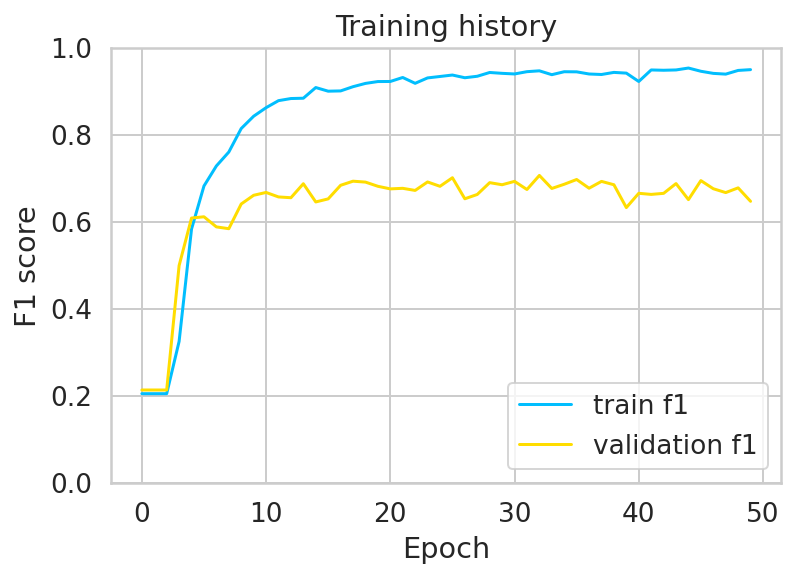

In [ ]:
plt.plot(history['train_f1'], label = 'train f1')
plt.plot(history['val_f1'], label = 'validation f1')

plt.title('Training history')

plt.ylabel('F1 score')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);

The model reaches its best performance at epoch 33. After that (and also few epochs before), the results stay around the same values.

### 1st experiment
- Higher hidden dimension - 200

In [ ]:
exp1_model = StanceClassifier(200)
exp1_model = exp1_model.to(device)

EPOCHS = 50 
BATCH_SIZE = 32

optimizer = AdamW(exp1_model.parameters(), lr = 1e-5)

loss_fn = nn.CrossEntropyLoss().to(device)

save_path = 'best_exp1_model_state.pt'

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
history, best_f1 = train_model(exp1_model,
                               EPOCHS,
                               BATCH_SIZE,
                               train_dataset,
                               val_dataset,
                               labels_dict,
                               loss_fn,
                               optimizer,
                               device,
                               save = True,
                               path = save_path)

Epoch 1/50
----------
Train: loss 1.096737597046829, F1 average 0.41501329430062817
Val: loss 1.0923794627189636, F1 average 0.3145539906103286

Epoch 2/50
----------
Train: loss 1.0893398973999955, F1 average 0.32474890548544944
Val: loss 1.0877902269363404, F1 average 0.3145539906103286

Epoch 3/50
----------
Train: loss 1.083636224269867, F1 average 0.32474890548544944
Val: loss 1.0834349036216735, F1 average 0.3145539906103286

Epoch 4/50
----------
Train: loss 1.0784131942725763, F1 average 0.32474890548544944
Val: loss 1.0792078495025634, F1 average 0.3145539906103286

Epoch 5/50
----------
Train: loss 1.070907927140957, F1 average 0.32474890548544944
Val: loss 1.0718285679817199, F1 average 0.3145539906103286

Epoch 6/50
----------
Train: loss 1.0634194801493388, F1 average 0.32916039908605554
Val: loss 1.0704190611839295, F1 average 0.43490499648135117

Epoch 7/50
----------
Train: loss 1.0551222809931127, F1 average 0.3415896973792896
Val: loss 1.0603728532791137, F1 average 0

In [ ]:
print('Best F1 score on the validation set: ' + str(best_f1))

Best F1 score on the validation set: 0.6764208945417


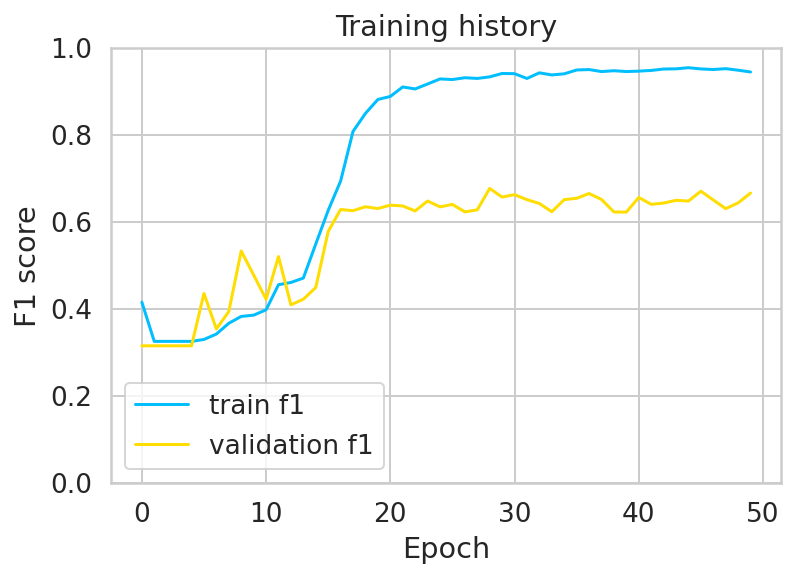

In [ ]:
plt.plot(history['train_f1'], label = 'train f1')
plt.plot(history['val_f1'], label = 'validation f1')

plt.title('Training history')

plt.ylabel('F1 score')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);

The best F1 score was obtained at epoch 29. However, this is sligthly worse than the best result found with the base model.

### 2nd experiment
- 2 stacked LSTMs with the best dimension found so far

In [ ]:
exp2_model = StanceClassifier(100, num_layers = 2)
exp2_model = exp2_model.to(device)

EPOCHS = 50 
BATCH_SIZE = 32

optimizer = AdamW(exp2_model.parameters(), lr = 1e-5)

loss_fn = nn.CrossEntropyLoss().to(device)

save_path = 'best_exp2_model_state.pt'

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
history, best_f1 = train_model(exp2_model,
                               EPOCHS,
                               BATCH_SIZE,
                               train_dataset,
                               val_dataset,
                               labels_dict,
                               loss_fn,
                               optimizer,
                               device,
                               save = True,
                               path = save_path)

Epoch 1/50
----------
Train: loss 1.0964329082791398, F1 average 0.20449029126213594
Val: loss 1.0929550409317017, F1 average 0.2129380053908356

Epoch 2/50
----------
Train: loss 1.0933979691528692, F1 average 0.39349717037417486
Val: loss 1.0910655975341796, F1 average 0.39295510950494184

Epoch 3/50
----------
Train: loss 1.0910292238723942, F1 average 0.37509238728750927
Val: loss 1.0891405582427978, F1 average 0.324251859539872

Epoch 4/50
----------
Train: loss 1.088552547664177, F1 average 0.32474890548544944
Val: loss 1.0871694684028625, F1 average 0.3145539906103286

Epoch 5/50
----------
Train: loss 1.086315351288493, F1 average 0.32474890548544944
Val: loss 1.0853450417518615, F1 average 0.3145539906103286

Epoch 6/50
----------
Train: loss 1.0838328716231556, F1 average 0.32474890548544944
Val: loss 1.083657479286194, F1 average 0.3145539906103286

Epoch 7/50
----------
Train: loss 1.081994536446362, F1 average 0.32474890548544944
Val: loss 1.0818260073661805, F1 average 0.

In [ ]:
print('Best F1 score on the validation set: ' + str(best_f1))

Best F1 score on the validation set: 0.6455550437586366


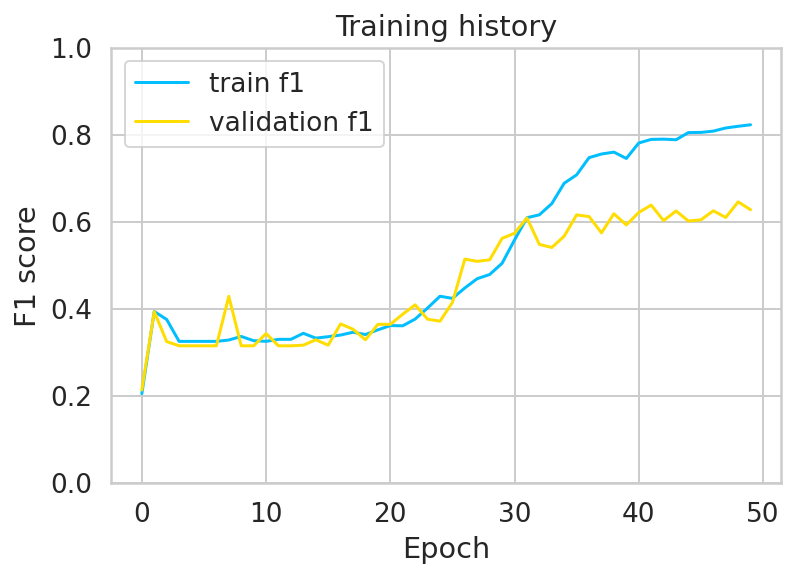

In [ ]:
plt.plot(history['train_f1'], label = 'train f1')
plt.plot(history['val_f1'], label = 'validation f1')

plt.title('Training history')

plt.ylabel('F1 score')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);

The scores are still going up towards the 50th epoch (the best was found at 49), so I'll continue the training for 20 more epochs.

In [ ]:
EPOCHS = 20

history, best_f1 = train_model(exp2_model,
                               EPOCHS,
                               BATCH_SIZE,
                               train_dataset,
                               val_dataset,
                               labels_dict,
                               loss_fn,
                               optimizer,
                               device,
                               save = True,
                               path = save_path)

Epoch 1/20
----------
Train: loss 0.9639977703734142, F1 average 0.8204877030557156
Val: loss 1.0205458879470826, F1 average 0.643155460157407

Epoch 2/20
----------
Train: loss 0.9624841598475852, F1 average 0.8092802067922027
Val: loss 1.0198696374893188, F1 average 0.6424735415026678

Epoch 3/20
----------
Train: loss 0.9580975952671795, F1 average 0.8268542839274546
Val: loss 1.0172331511974335, F1 average 0.6424623943198038

Epoch 4/20
----------
Train: loss 0.9556780857283894, F1 average 0.8354031666142394
Val: loss 1.0219158947467804, F1 average 0.6379938358083497

Epoch 5/20
----------
Train: loss 0.9523724833639656, F1 average 0.8564903429875362
Val: loss 1.0170344114303589, F1 average 0.6460461430081015

Epoch 6/20
----------
Train: loss 0.9507122330549287, F1 average 0.864946138672332
Val: loss 1.0105939507484436, F1 average 0.6438988408851423

Epoch 7/20
----------
Train: loss 0.9458808288341616, F1 average 0.8989290853879319
Val: loss 1.0113649487495422, F1 average 0.66532

In [ ]:
print('Best F1 score on the validation set: ' + str(best_f1))

Best F1 score on the validation set: 0.6823600727419681


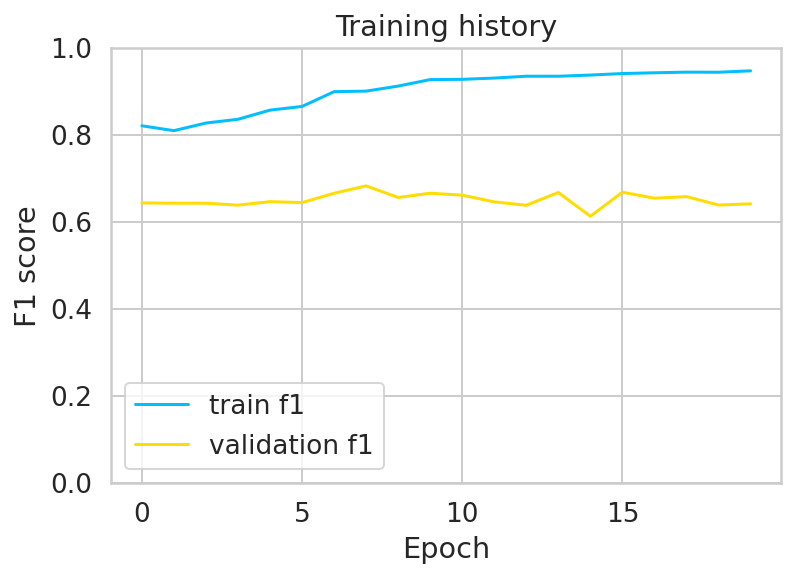

In [ ]:
plt.plot(history['train_f1'], label = 'train f1')
plt.plot(history['val_f1'], label = 'validation f1')

plt.title('Training history')

plt.ylabel('F1 score')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);

The scores started to not improve anymore near the end of this additional training. However, it allowed to obtain the best result for this model, which was found at epoch 58: still, this is a bit lower than the one from the base model.

In [ ]:
# to download the best model model

!zip -r /content/best_model.zip /content/best_base_model_state.pt

### Failed experiments
- 2 LSTMs after tweet embedding, but with different hidden dimensions(first hidden dim = 300, then 100)
  - i stopped the training after 30 epochs: the scores were stuck at the same values seen from the start

## Evaluation

For the final evaluation, we'll use the best model found (the base model) on the two test sets provided:
- the first are unseen data belonging to the targets already seen in the training set;
- the second, on the other hand, contains only texts about a new target, not seen during training.

### Prepare test sets

In [24]:
# load data

test_df = pd.read_csv('/content/semEval2016/test.txt', sep='\t')
test_df.head()

,ID,Target,Tweet,Stance,Opinion towards,Sentiment
0,10001,Atheism,He who exalts himself shall be humbled; a...,AGAINST,TARGET,POSITIVE
1,10002,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,AGAINST,TARGET,NEITHER
2,10003,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,AGAINST,TARGET,POSITIVE
3,10004,Atheism,#God is utterly powerless without Human interv...,AGAINST,TARGET,NEGATIVE
4,10005,Atheism,@David_Cameron Miracles of #Multiculturalism...,AGAINST,OTHER,NEGATIVE


In [25]:
len(test_df)

1249

In [26]:
test_df['Target'].unique()

array(['Atheism', 'Climate Change is a Real Concern', 'Feminist Movement',
       'Hillary Clinton', 'Legalization of Abortion'], dtype=object)

In [27]:
# test set with new target

test_new_df = pd.read_csv('/content/semEval2016/test_new_target.txt', sep='\t')
test_new_df.head()

,ID,Target,Tweet,Stance,Opinion towards,Sentiment
0,20001,Donald Trump,@2014voteblue @ChrisJZullo blindly supporting ...,NONE,OTHER,NEGATIVE
1,20002,Donald Trump,@ThePimpernelX @Cameron_Gray @CalebHowe Total...,NONE,OTHER,POSITIVE
2,20003,Donald Trump,@JeffYoung @ThePatriot143 I fully support full...,NONE,OTHER,POSITIVE
3,20004,Donald Trump,@ABC Stupid is as stupid does! Showedhis true ...,AGAINST,TARGET,NEGATIVE
4,20005,Donald Trump,@HouseGOP we now have one political party. The...,NONE,OTHER,NEGATIVE


In [28]:
len(test_new_df)

707

In [29]:
test_new_df['Target'].unique()

array(['Donald Trump'], dtype=object)

In [ ]:
def prepare_data(df, labels_dict, tokenizer, max_tweet_len, max_target_len):

  '''
  Return a StanceDataset object from the initial dataframe
  '''

  # remove not-useful columns
  df = df.drop(['ID', 'Opinion towards', 'Sentiment'], axis = 1)

  # clean tweets
  df['cleaned_tweet'] = df.apply(lambda row: normalizeTweet(row['Tweet']), axis = 1)

  # numerical stances
  pd_num_stances = df['Stance'].map(labels_dict)
  stances = torch.tensor(pd_num_stances.to_list())

  # tokenization
  tweets = df['cleaned_tweet'].to_list()
  targets = df['Target'].to_list()

  enc_tweets = tokenizer(tweets, padding = True, truncation = True, max_length = max_tweet_len, return_tensors = 'pt')
  enc_targets = tokenizer(targets, padding = True, truncation = True, max_length = max_target_len, return_tensors = 'pt')

  # check
  #print(enc_tweets['input_ids'].shape, enc_targets['input_ids'].shape)

  dataset = StanceDataset(enc_tweets,
                          enc_targets,
                          stances)
  
  return dataset


In [ ]:
test_dataset = prepare_data(test_df, labels_dict, tokenizer, MAX_TWEET_LEN, MAX_TARGET_LEN)
test_new_dataset = prepare_data(test_new_df, labels_dict, tokenizer, MAX_TWEET_LEN, MAX_TARGET_LEN)

### Compute results

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/NLP_project_work/best_model.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/NLP_project_work/best_model.zip
  inflating: content/best_base_model_state.pt  


In [ ]:
model_state_path = '/content/content/best_base_model_state.pt'

model = StanceClassifier(100)
model = model.to(device)
model.load_state_dict(torch.load(model_state_path))

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

#### Test

In [ ]:
# dataloader

BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

# evaluation
test_f1, _ = eval_model(model = model,
                        data_loader = test_loader,
                        labels_dict = labels_dict,
                        loss_fn = None,
                        device = device)

print('F1 average on test set: ' + str(test_f1))


F1 average on test set: 0.6424772608514671


#### Test set with new target

In [ ]:
# dataloader

test_new_loader = DataLoader(test_new_dataset, batch_size = BATCH_SIZE)

# evaluation
test_new_f1, _ = eval_model(model = model,
                            data_loader = test_new_loader,
                            labels_dict = labels_dict,
                            loss_fn = None,
                            device = device)

print('F1 average on test set with new target: ' + str(test_new_f1))

F1 average on test set with new target: 0.22895733816504696
